# Aloglia - Trending Searches

The provided dataset contains one month of anonymized aggregated searches coming from HN Search. In this case study, we want to provide trending searches to the user. Trending Queries can be seen as search recommendations for users, or as an internal insight/metric/boost.

We define a trending query as a positive variation of search occurences during a certain period of time.

For each query, we produce a time serie vector representing the evolution of the query occurences by days and calculate the slope of the time serie based on a linear regression.

The top N queries whith the highest slope will be suggested as the trending searches.


In [1]:
from os import listdir
from os.path import isfile, join
import json
import numpy as np
from scipy import stats
import operator
import string

We make the following assumption to keep a query as a candidate for a trending search: 
* the query must not be empty
* the query must be equal or more than 3 chars
* the query must provide search results (in order to not suggest queries that retrieve no result to the user)

In [2]:
def validate_query(data):
    # Remove punctuation
    query = data['query'].translate(string.punctuation)
    if not query or len(query) < 3 or data['nb_hits'] <= 0:
        return False
    return True

In [3]:
path = "workspace/algolia/hn_insights_data/"
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

queries = {};
i=0
for f in files:
    with open(path + f, 'r') as logs:
         for line in logs.readlines():
                try:
                    # load json data
                    data = json.loads(line)
                    
                    # check if the query is a valid query
                    if validate_query(data):
                        
                        #create the vector of the search occurences
                        if data['query'] in queries:
                            vector = queries[data['query']]
                            vector[i]+=1
                        else:
                            vector = np.zeros((len(files),), dtype=int)
                            vector[i] = 1
                        queries[data['query']] = vector
                except ValueError:
                    ## Line is not a valid JSON, we skip this line
                    ## print("JSON decode as failed for line: %s" %line)
                    continue
    i+=1

#### We display an exemple of the evolotion of search occurences for the query "python" during the month.

In [4]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(queries['python'])), queries['python'], label="python")
plt.ylabel('nb occurences')
plt.show()



<Figure size 640x480 with 1 Axes>

#### Now, we calculate the slop of the curve for each query using linear regression

In [5]:
slopes = {}
intercepts = {}
x=np.arange(len(files))
for q in queries:
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, queries[q])
    if slope > 0:
        slopes[q] = slope
        intercepts[q]= intercept
    #print("%s | %s | %s" %(q, queries[q], slope))

#### We print the top 5 queries with the highest slope values

In [6]:
sorted_slopes = sorted(slopes.items(), key=operator.itemgetter(1), reverse=True)
n=1
for slope in sorted_slopes:
    print(slope)
    n+=1
    if n>10:
        break

('python', 8.452419354838709)
('magic leap', 2.8491935483870963)
('macbook', 2.713709677419355)
('guido', 2.4403225806451614)
('bitwarden', 1.7624999999999997)
('hiring', 1.4338709677419357)
('who is hiring', 1.4310483870967743)
('npm', 1.3713709677419352)
('MBasic Facebook', 1.2076612903225805)
('Billionaire’s Secret Buyout Formula: 110 Instructions and an Intelligence Test', 1.2036290322580645)


#### We display the trending curves of the top 3 trending searches

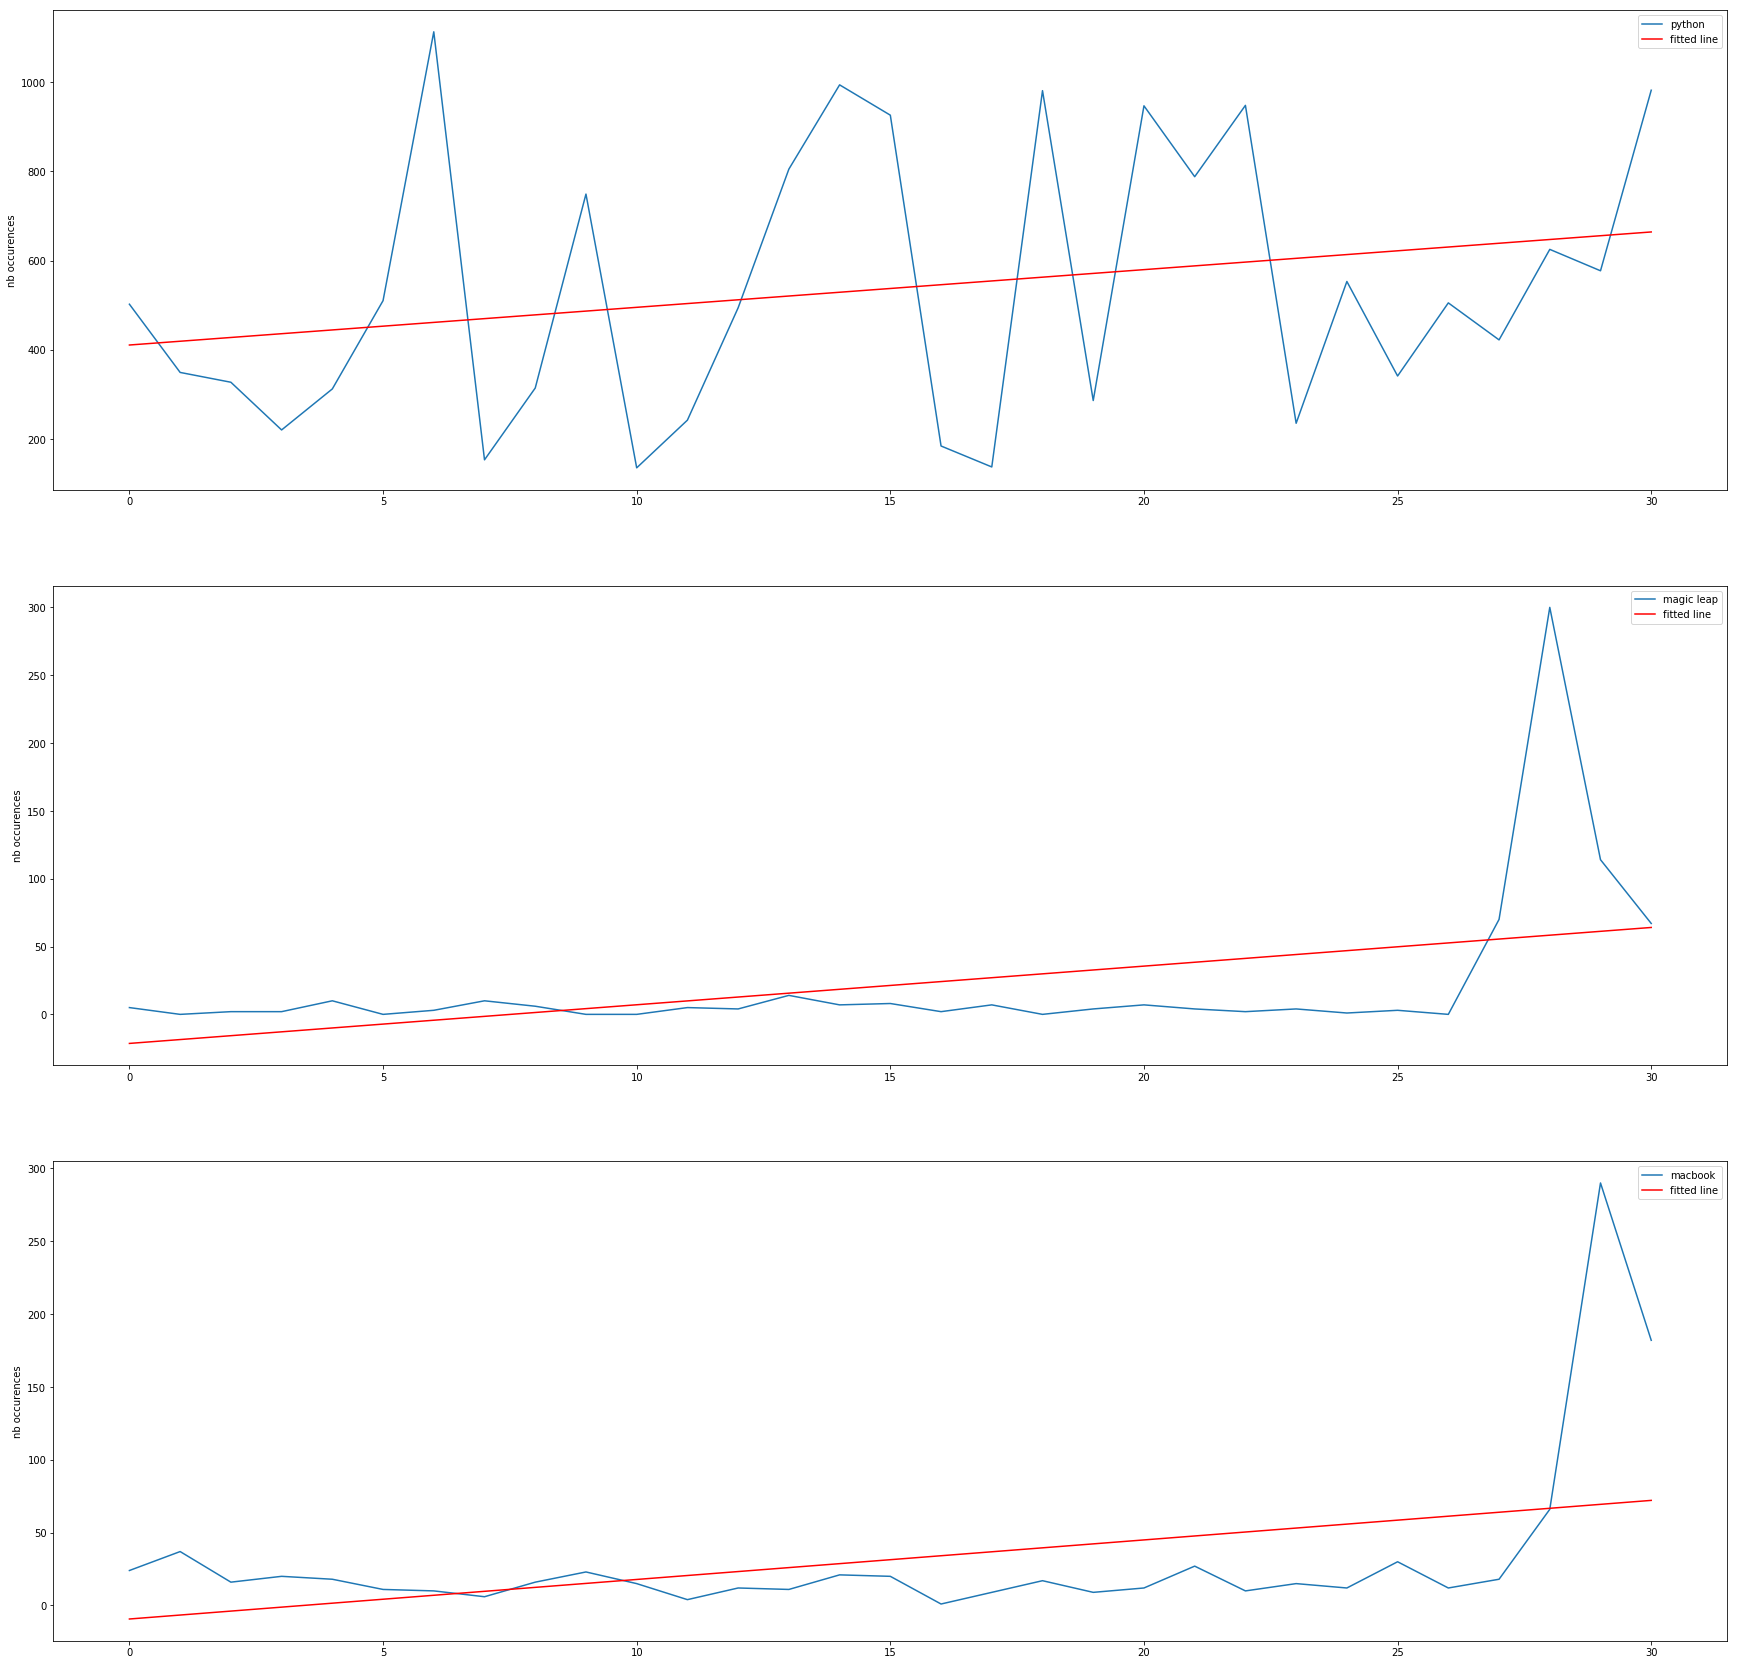

In [7]:
plt.figure(figsize=(30, 30))
plt.subplot(311)
plt.plot(np.arange(len(queries['python'])), queries['python'], label="python")
plt.plot(x, intercepts['python'] + slopes['python']*x, 'r', label='fitted line')
plt.ylabel('nb occurences')
plt.legend()

plt.subplot(312)
plt.plot(np.arange(len(queries['magic leap'])), queries['magic leap'], label="magic leap")
plt.plot(x, intercepts['magic leap'] + slopes['magic leap']*x, 'r', label='fitted line')
plt.ylabel('nb occurences')
plt.legend()

plt.subplot(313)
plt.plot(np.arange(len(queries['macbook'])), queries['macbook'], label="macbook")
plt.plot(x, intercepts['macbook'] + slopes['macbook']*x, 'r', label='fitted line')
plt.ylabel('nb occurences')
plt.legend()

plt.show()

### Get trending searches for a specific day
If we want to have the latest fresh trends, we can vary the period on which we calculate our slope.
For example, we can only caclulate the slope on the last three days to provide the trends for the 7th July 2018.

In [8]:
slopes = {}
intercepts = {}
for q in queries:
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(3), queries[q][20:23])
    if slope > 0:
        slopes[q] = slope
        intercepts[q]= intercept

In [9]:
sorted_slopes = sorted(slopes.items(), key=operator.itemgetter(1), reverse=True)
n=1
for slope in sorted_slopes:
    print(slope)
    n+=1
    if n>10:
        break

('Dear Software Engineer', 66.0)
('java native pjmlp', 49.99999999999999)
('kubernetes', 49.0)
('salary', 30.0)
('Dear software engineer, You’re a piece of shit', 27.5)
('kotlin', 21.0)
('rust', 21.0)
('musk', 20.0)
('sonos', 17.5)
('soviet', 16.5)


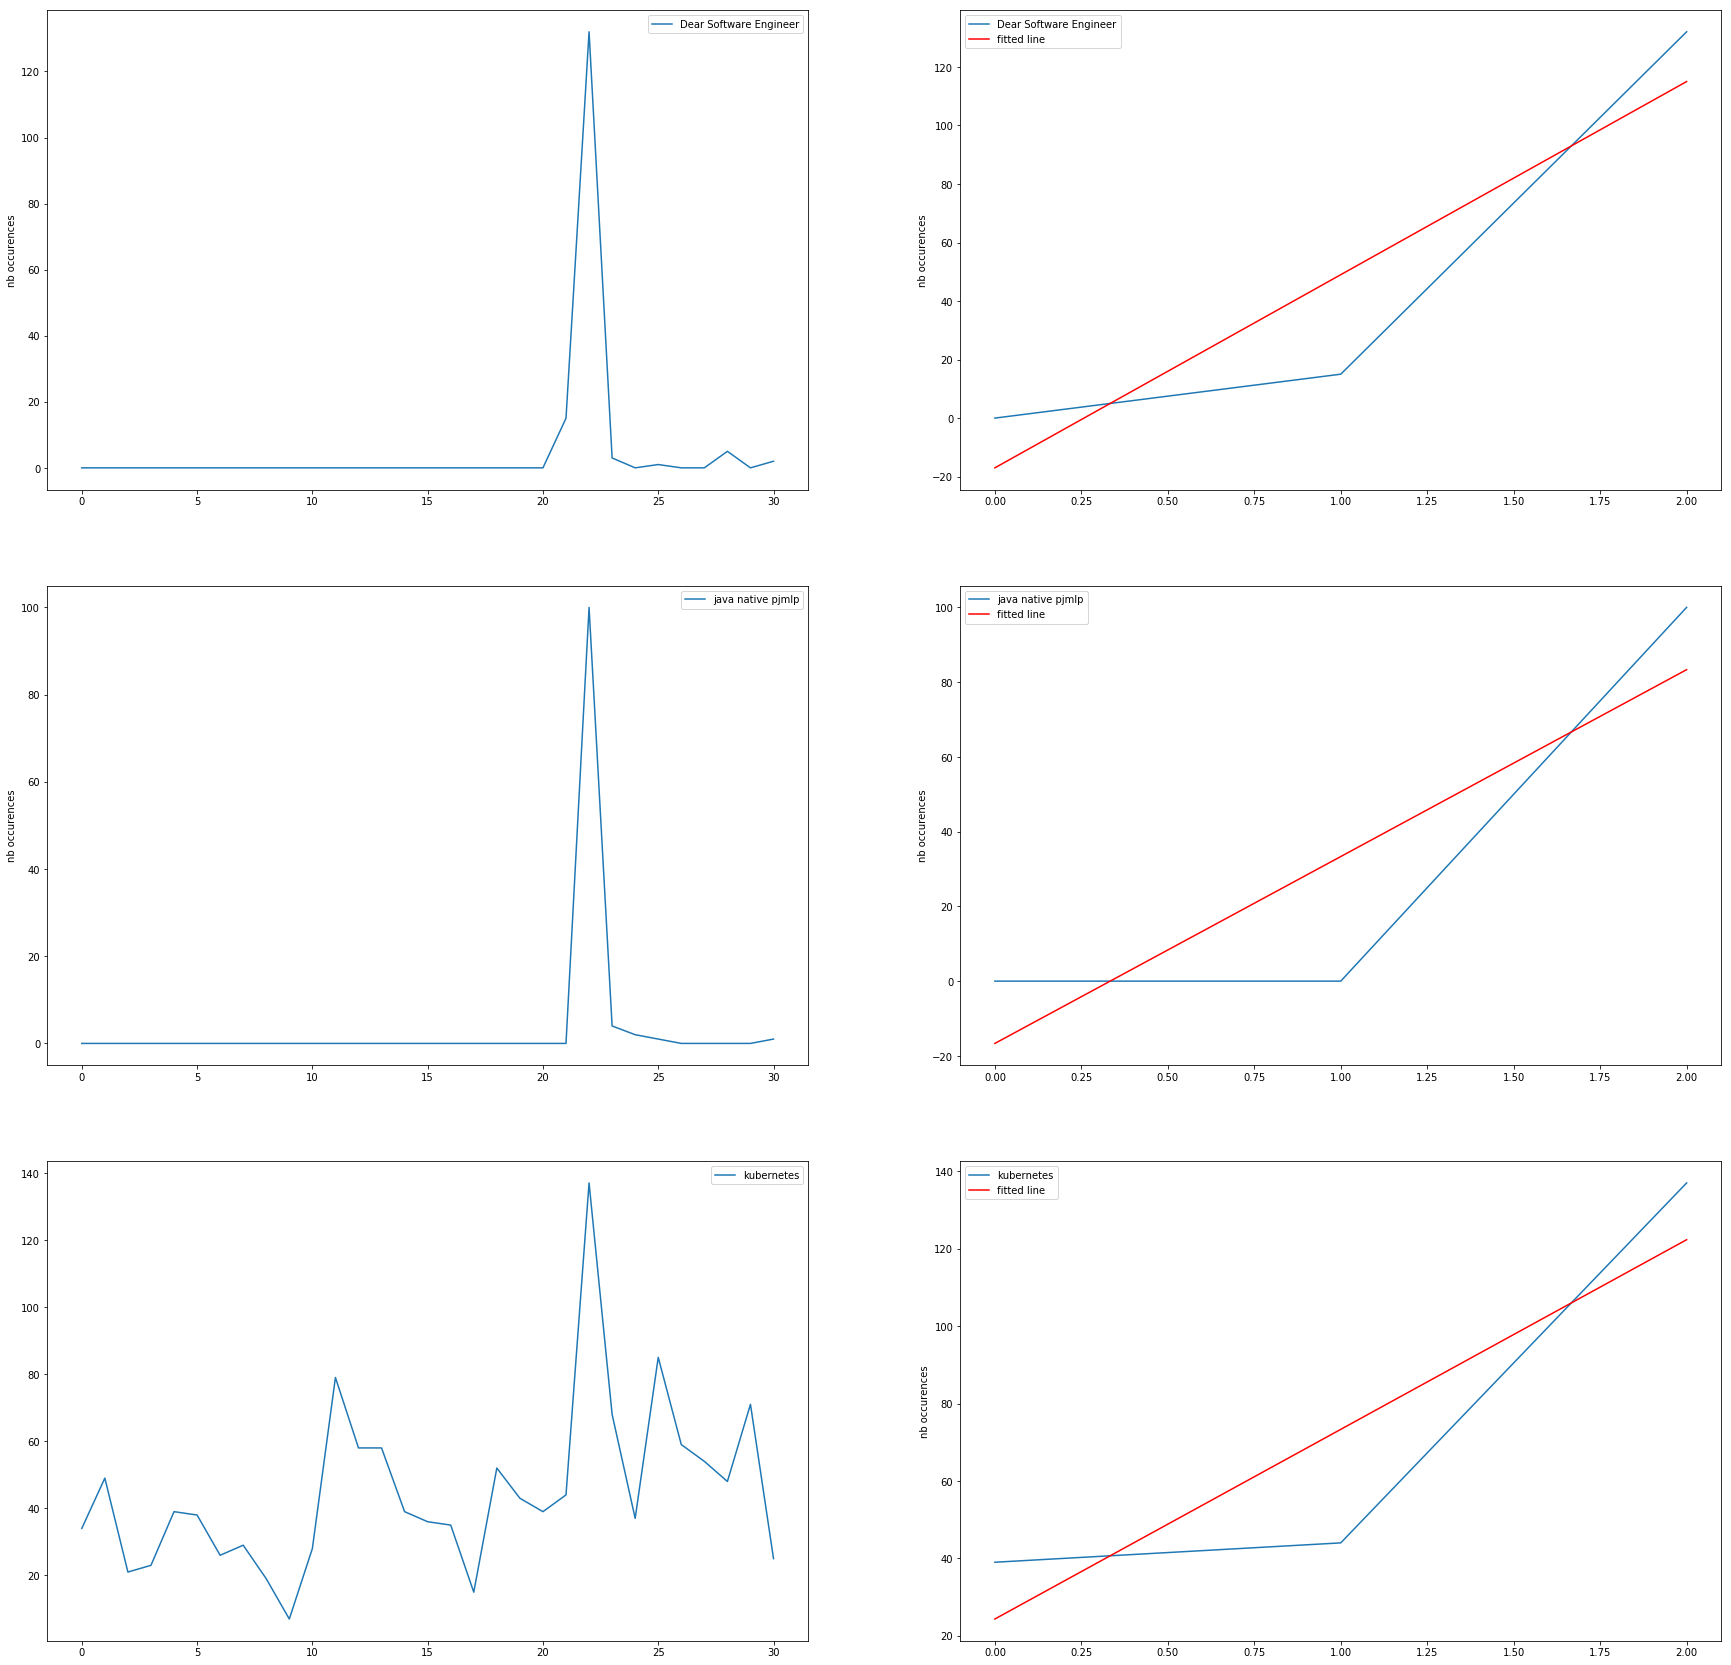

In [10]:
plt.figure(figsize=(30, 30))

# Display month search occurences and the trending slope on the last 3 days for query "python"
plt.subplot(321)
plt.plot(np.arange(len(queries['Dear Software Engineer'])), queries['Dear Software Engineer'], label="Dear Software Engineer")
plt.ylabel('nb occurences')
plt.legend()
plt.subplot(322)
plt.plot(np.arange(3), queries['Dear Software Engineer'][20:23], label="Dear Software Engineer")
plt.plot(np.arange(3), intercepts['Dear Software Engineer'] + slopes['Dear Software Engineer']*np.arange(3), 'r', label='fitted line')
plt.ylabel('nb occurences')
plt.legend()

# Display month search occurences and the trending slope on the last 3 days for query "wework"
plt.subplot(323)
plt.plot(np.arange(len(queries['java native pjmlp'])), queries['java native pjmlp'], label="java native pjmlp")
plt.ylabel('nb occurences')
plt.legend()
plt.subplot(324)
plt.plot(np.arange(3), queries['java native pjmlp'][20:23], label="java native pjmlp")
plt.plot(np.arange(3), intercepts['java native pjmlp'] + slopes['java native pjmlp']*np.arange(3), 'r', label='fitted line')
plt.ylabel('nb occurences')
plt.legend()

# Display month search occurences and the trending slope on the last 3 days for query "macbook"
plt.subplot(325)
plt.plot(np.arange(len(queries['kubernetes'])), queries['kubernetes'], label="kubernetes")
plt.legend()
plt.subplot(326)
plt.plot(np.arange(3), queries['kubernetes'][20:23], label="kubernetes")
plt.plot(np.arange(3), intercepts['kubernetes'] + slopes['kubernetes']*np.arange(3), 'r', label='fitted line')
plt.ylabel('nb occurences')
plt.legend()

plt.show()

## Conclusion
#### Resume
Linear regression is a simple and a good way to provide trending searches according to the assumption we want to display not the most popular searches, but a positive evolution of the search occurences on a certain period. The “Trendiness”/”Hotness” can be divided on several timelines: hourly, daily, weekly, monthly, etc.

According to the provided dataset, we process the trending search for a monthly period and for a specific day.
On a monthly period, the top 3 trending searches are the queries "python", "magic leap" and "macbook".
For a specific day, we chose to compute the linear regression the 3 previous days. As example, we get "Dear Software Engineer", "java native pjmlp" and "kubernetes" as the top 3 trending search for the July 7th 2018.

#### Limits of the proposed approach
There are several limitations in the proposed solution:
* The linear regression on only 3 points could be not efficient to modelize the data. This modelisation could be sensitive to periodic (weekend, dayoff) or seasonality (holidays) events. Using a non-linear regression or additive regression model should improve the trend detection or prediction. For example, the Prophet library (https://github.com/facebook/prophet) allows to forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

* Another issue that we could notice is that some trending queries lead to the same needs (or set of records). This issue could be solve using NLP techniques (token in common,  Levenshtein distance, external ressources, ...) to guess that queries are semantically close. A second solution could be to deduplicate trending queries that leads to the same clicked records (using cosine similarity) 




